In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [2]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
import keras.backend as K

def categorical_focal_loss(alpha, gamma=2.):

    alpha = np.array(alpha, dtype=np.float32)

    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))

    return categorical_focal_loss_fixed

## Data Loading

In [4]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [5]:
train_path = 'C:/Users/wweis/Deep Learning/Drowsy/data/train'
test_path = 'C:/Users/wweis/Deep Learning/Drowsy/data/valid'

In [6]:
# useful for getting number of classes
folders = glob('C:/Users/wweis/Deep Learning/Drowsy/data/train/*')
print("Number of folders,\n",folders)

Number of folders,
 ['C:/Users/wweis/Deep Learning/Drowsy/data/train\\Closed', 'C:/Users/wweis/Deep Learning/Drowsy/data/train\\no_yawn', 'C:/Users/wweis/Deep Learning/Drowsy/data/train\\Open', 'C:/Users/wweis/Deep Learning/Drowsy/data/train\\yawn']


## Data Augmentation

In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('C:/Users/wweis/Deep Learning/Drowsy/data/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=42)

validation_set = test_datagen.flow_from_directory(
        'C:/Users/wweis/Deep Learning/Drowsy/data/valid',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=True,
        seed=42)

test_set = test_datagen.flow_from_directory('C:/Users/wweis/Deep Learning/Drowsy/data/test',
                                            target_size = (224, 224),
                                            batch_size=1,
                                            class_mode='categorical',
                                            shuffle=False,
                                            seed=42)

Found 2030 images belonging to 4 classes.
Found 290 images belonging to 4 classes.
Found 580 images belonging to 4 classes.


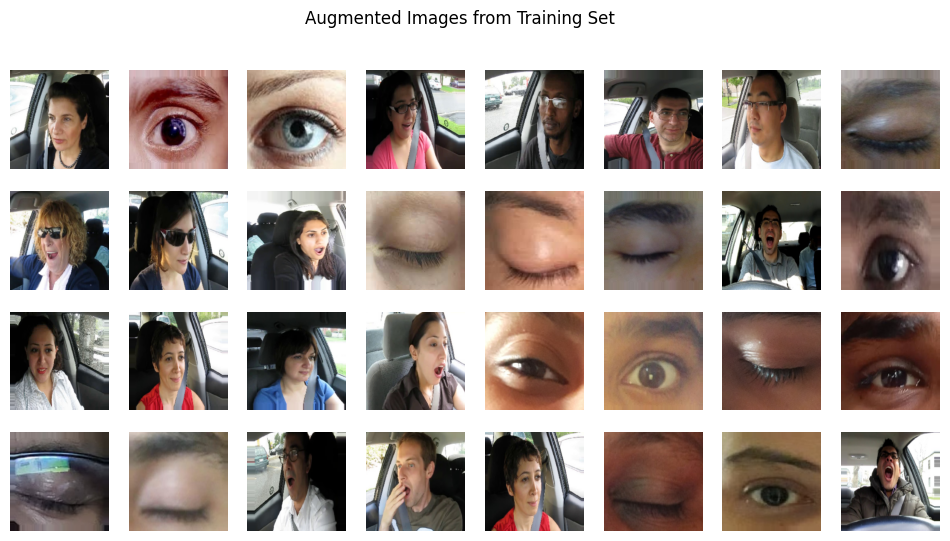

In [8]:
# Get a batch of augmented images from the training set
augmented_images, labels = training_set.next()

# Display the augmented images
fig, axs = plt.subplots(4, 8, figsize=(12, 6))
fig.suptitle('Augmented Images from Training Set')

for i, ax in enumerate(axs.flat):
    ax.imshow(augmented_images[i])
    ax.axis('off')

plt.show()

In [9]:
# Get a batch of images from the training set
batch_images, batch_labels = training_set.next()

# Convert the batch images to a numpy array
batch_array = np.array(batch_images)

# Print the shape of the batch array
print(batch_array)

[[[[0.6682703  0.5584664  0.5153291 ]
   [0.6738297  0.56402576 0.52088845]
   [0.6637902  0.5539863  0.51084906]
   ...
   [0.5866317  0.53805673 0.5058824 ]
   [0.5856906  0.5347102  0.5033377 ]
   [0.5803746  0.5293942  0.49802163]]

  [[0.6682703  0.5584664  0.5153291 ]
   [0.6738297  0.56402576 0.52088845]
   [0.6637902  0.5539863  0.51084906]
   ...
   [0.5866317  0.53805673 0.5058824 ]
   [0.5856906  0.5347102  0.5033377 ]
   [0.5803746  0.5293942  0.49802163]]

  [[0.6682703  0.5584664  0.5153291 ]
   [0.6738297  0.56402576 0.52088845]
   [0.6637902  0.5539863  0.51084906]
   ...
   [0.5866317  0.53805673 0.5058824 ]
   [0.5856906  0.5347102  0.5033377 ]
   [0.5803746  0.5293942  0.49802163]]

  ...

  [[0.51916325 0.44073185 0.41328087]
   [0.5095772  0.43114585 0.40369487]
   [0.5062308  0.42779937 0.4003484 ]
   ...
   [0.7388586  0.67219186 0.6447409 ]
   [0.7347103  0.6680436  0.64059263]
   [0.735303   0.66863626 0.6411853 ]]

  [[0.51916325 0.44073185 0.41328087]
   [0.5

In [10]:
print(len(training_set))
print(len(training_set.classes))

64
2030


## Pretrained VGG-16

In [11]:
# add preprocessing layer to the front of VGG
# vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
vgg = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [12]:
x = Flatten()(vgg.output)
# x = Flatten()(vgg.get_layer('block5_pool').output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
model.compile(
  loss='categorical_crossentropy',
#   loss=categorical_focal_loss(alpha=0.25, gamma=2),
  optimizer='adam',
  metrics=['accuracy']
)

In [15]:
hist = model.fit(
  training_set,
  validation_data=validation_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set),
  verbose=1
)

Epoch 1/20
64/64 [==============================] - 36s 440ms/step - loss: 0.5629 - accuracy: 0.7571 - val_loss: 0.3257 - val_accuracy: 0.8414
Epoch 2/20
64/64 [==============================] - 23s 360ms/step - loss: 0.2509 - accuracy: 0.8867 - val_loss: 0.1739 - val_accuracy: 0.9241
Epoch 3/20
64/64 [==============================] - 24s 368ms/step - loss: 0.1737 - accuracy: 0.9315 - val_loss: 0.1338 - val_accuracy: 0.9517
Epoch 4/20
64/64 [==============================] - 23s 356ms/step - loss: 0.1414 - accuracy: 0.9443 - val_loss: 0.1094 - val_accuracy: 0.9621
Epoch 5/20
64/64 [==============================] - 23s 360ms/step - loss: 0.1392 - accuracy: 0.9502 - val_loss: 0.1918 - val_accuracy: 0.9276
Epoch 6/20
64/64 [==============================] - 23s 354ms/step - loss: 0.1202 - accuracy: 0.9591 - val_loss: 0.2334 - val_accuracy: 0.9172
Epoch 7/20
64/64 [==============================] - 23s 361ms/step - loss: 0.1902 - accuracy: 0.9207 - val_loss: 0.1163 - val_accuracy: 0.9586

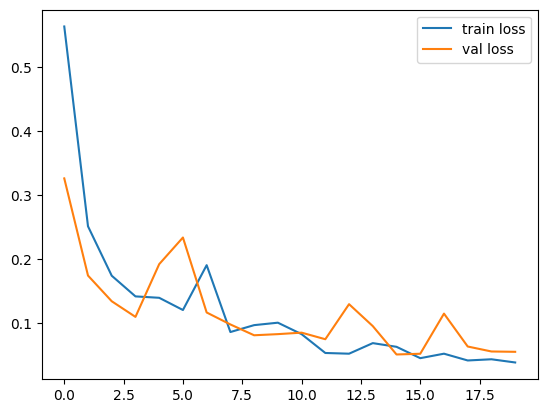

<Figure size 640x480 with 0 Axes>

In [16]:
# loss
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

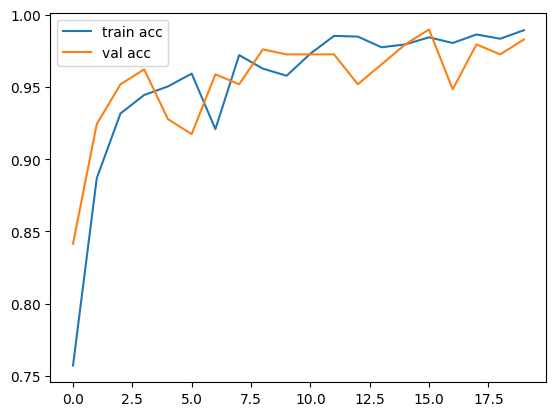

<Figure size 640x480 with 0 Axes>

In [17]:
plt.plot(hist.history['accuracy'], label='train acc')
plt.plot(hist.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

## Model Evaluation

In [18]:
model.evaluate(test_set, steps=len(test_set))

580/580 [==============================] - 11s 19ms/step - loss: 0.0950 - accuracy: 0.9621


[0.09497610479593277, 0.9620689749717712]

In [19]:
STEP_SIZE_TEST=test_set.n//test_set.batch_size
test_set.reset()
pred=model.predict(test_set,
                   steps=STEP_SIZE_TEST,
                   verbose=1)

580/580 [==============================] - 10s 16ms/step


In [20]:
predicted_class_indices=np.argmax(pred,axis=1)

In [23]:
# Define a list of label names
label_names = ['Closed', 'no_yawn', 'Open', 'yawn']

# Get the predicted labels for the test data
# pred_labels = np.argmax(model.predict(test_set), axis=1)
pred_labels = np.argmax(pred, axis=1)

# Get the number of unique labels
num_labels = len(np.unique(test_set.classes))

# Compute the accuracy for each label
label_accs = {}
for label in range(num_labels):
    idx = np.where(test_set.classes == label)[0]
    label_acc = np.mean(pred_labels[idx] == test_set.classes[idx])
    label_accs[label_names[label]] = label_acc

# Print the accuracy for each label
for label, acc in label_accs.items():
    print(f"Accuracy for label {label}: {acc:.2f}")

Accuracy for label Closed: 0.98
Accuracy for label no_yawn: 0.97
Accuracy for label Open: 0.96
Accuracy for label yawn: 0.94


Text(0.5, 25.722222222222214, 'Actual')

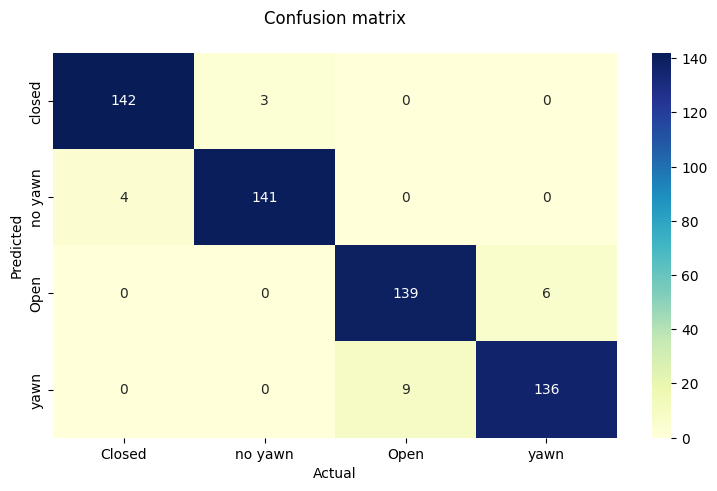

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

plt.figure(figsize=(20, 5))

# Make predictions on the test set
# y_pred = model.predict(test_set)

# Get the true labels for the test set
y_true = test_set.classes

# Compute the confusion matrix
conf_mat = confusion_matrix(y_true, predicted_class_indices)

df_cm = pd.DataFrame(conf_mat, index=['closed', 'no yawn', 'Open', 'yawn'], columns=['Closed', 'no yawn', 'Open', 'yawn'])
plt.subplot(121)
plt.title("Confusion matrix\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

In [25]:
from sklearn.metrics import classification_report

# Assuming y_true and y_pred are the true and predicted labels
report = classification_report(y_true, predicted_class_indices)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       145
           1       0.98      0.97      0.98       145
           2       0.94      0.96      0.95       145
           3       0.96      0.94      0.95       145

    accuracy                           0.96       580
   macro avg       0.96      0.96      0.96       580
weighted avg       0.96      0.96      0.96       580



In [26]:
# # Saving the model
# import tensorflow as tf

# from keras.models import load_model

# model.save('Drowsiness_detection_vgg16.h5')